<a href="https://colab.research.google.com/github/noviantisafitri/Prediksi-Penyakit-Diabetes/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Penyakit Diabetes

Notebook ini berisi tahapan analisis data dan pembangunan model machine learning untuk memprediksi kemungkinan seseorang menderita diabetes menggunakan dataset dari Kaggle.

[Dataset](https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Memuat Dataset
Dataset diambil dari GitHub dan dimuat ke dalam DataFrame menggunakan Pandas.

In [2]:
url = "https://raw.githubusercontent.com/noviantisafitri/Prediksi-Penyakit-Diabetes/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Lima baris pertama dataset menunjukkan informasi medis dari pasien, termasuk jumlah kehamilan, kadar glukosa, tekanan darah, ketebalan lipatan kulit, tingkat insulin, indeks massa tubuh (BMI), riwayat diabetes keluarga, usia, serta label diagnosis (Outcome). Misalnya, pasien pertama memiliki 6 kali kehamilan, kadar glukosa 148, BMI 33.6, dan berusia 50 tahun, serta terdiagnosis diabetes (Outcome = 1). Terlihat juga adanya nilai 0 pada beberapa kolom seperti insulin dan skin thickness yang kemungkinan merupakan data hilang. Secara keseluruhan, dataset ini mencerminkan variabel-variabel penting yang dapat digunakan untuk memprediksi risiko diabetes pada individu.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Output diatas menunjukkan bahwa dataset terdiri dari 768 baris dan 9 kolom tanpa missing values (semua kolom memiliki 768 entri). Terdapat 7 kolom bertipe data int64 seperti Pregnancies, Glucose, dan Outcome, serta 2 kolom bertipe float64, yaitu BMI dan DiabetesPedigreeFunction.

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Output diatas menunjukkan bahwa nilai Rata-rata (mean) kadar glukosa adalah 120.89, tekanan darah 69.10, dan BMI 31.99. Namun, nilai minimum pada kolom seperti Glucose, BloodPressure, SkinThickness, Insulin, dan BMI adalah 0, yang secara medis tidak logis dan kemungkinan mencerminkan data yang hilang atau tidak tercatat. Rentang nilai juga menunjukkan adanya outlier, contohnya pada kolom Insulin yang memiliki nilai maksimum 846. Nilai tengah (median) pada kolom Outcome adalah 0, yang menunjukkan bahwa lebih banyak pasien tidak menderita diabetes dibandingkan yang menderita.

## Mengecek Missing Values dan Data Duplikat

In [5]:
print("Missing Values:\n")
df.isnull().sum()

Missing Values:



,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Output tersebut menunjukkan bahwa tidak ada missing values secara eksplisit dalam dataset (semua kolom memiliki jumlah data lengkap sebanyak 768 entri).

In [6]:
print("\nDuplicate Entries:")
df.duplicated().sum()


Duplicate Entries:


np.int64(0)

Output tersebut menunjukkan bahwa tidak ada baris duplikat dalam dataset — artinya semua 768 entri adalah unik dan tidak ada baris yang identik sepenuhnya.

## Visualisasi Korelasi dan Distribusi Fitur

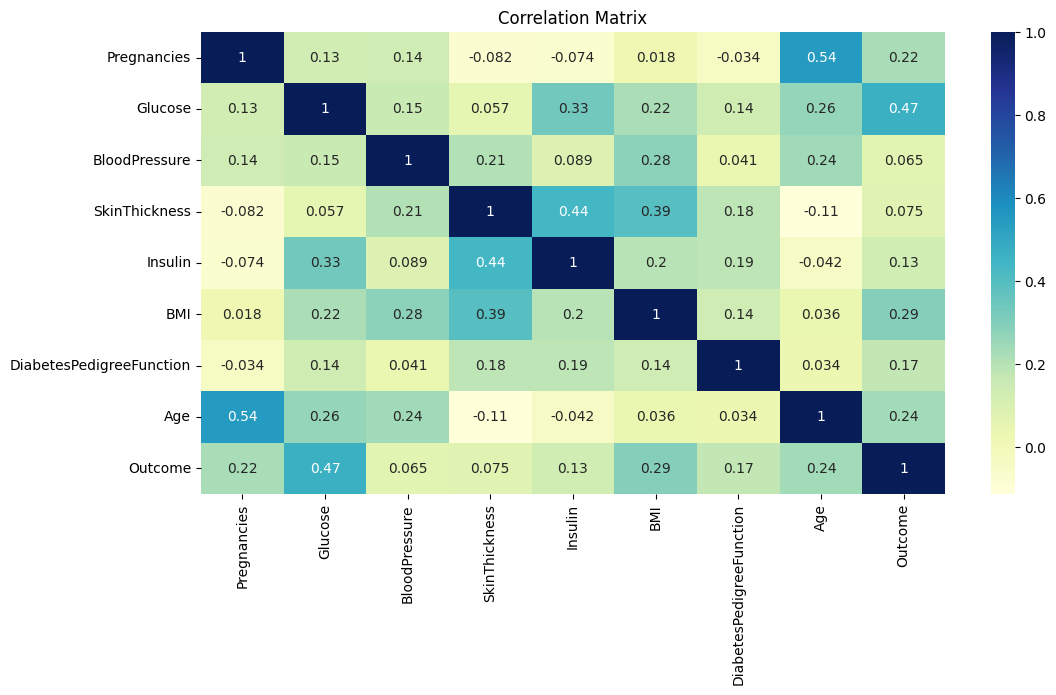

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

Berdasarkan matriks korelasi, fitur yang paling berkorelasi dengan kemungkinan diabetes (Outcome) adalah Glucose (0.47), diikuti oleh BMI (0.29), Age (0.24), dan Pregnancies (0.22), yang menunjukkan bahwa kadar glukosa darah, indeks massa tubuh, usia, dan jumlah kehamilan memiliki hubungan positif terhadap risiko diabetes. Sementara itu, fitur seperti BloodPressure, SkinThickness, dan Insulin memiliki korelasi yang sangat lemah terhadap Outcome. Korelasi antar fitur juga menunjukkan hubungan yang masuk akal, seperti antara SkinThickness dan BMI (0.39), serta antara Pregnancies dan Age (0.54), yang mendukung validitas struktur data ini dari sisi medis dan demografis.

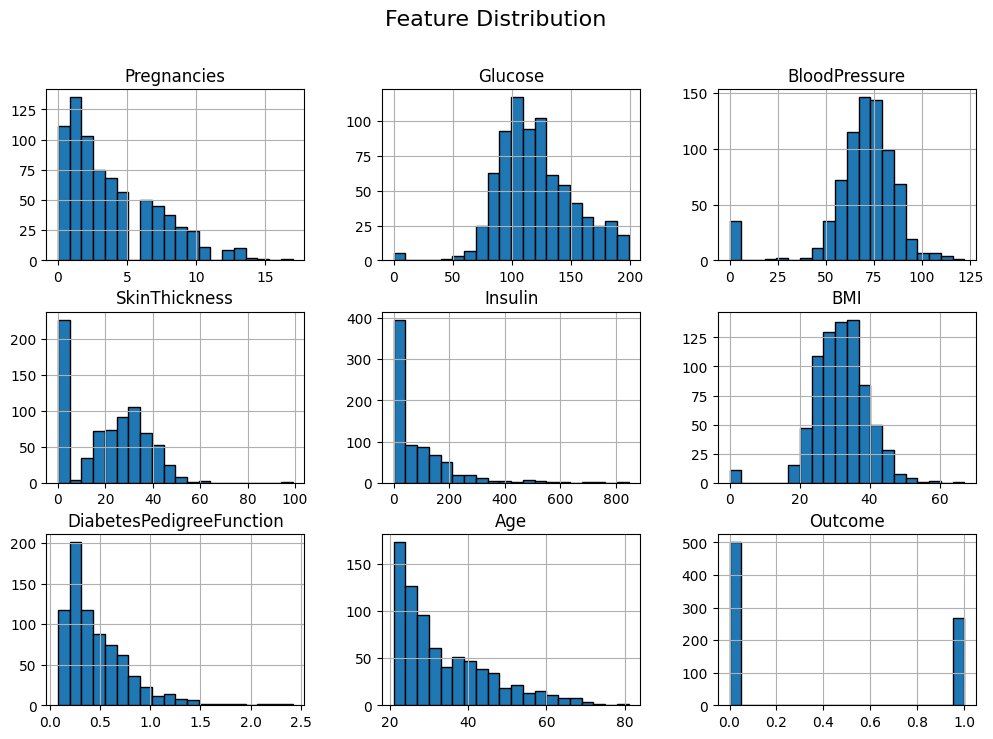

In [8]:
df.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distribution", fontsize=16)
plt.show()

- Pregnancies: Distribusinya miring ke kanan (positively skewed). Sebagian besar individu memiliki jumlah kehamilan yang rendah (0-5), dan frekuensinya menurun seiring dengan bertambahnya jumlah kehamilan. Terdapat beberapa individu dengan jumlah kehamilan yang relatif tinggi.

- Glucose: Distribusinya mendekati normal, namun sedikit miring ke kanan. Sebagian besar nilai glukosa terpusat di sekitar nilai tengah, dengan frekuensi yang menurun secara bertahap ke arah nilai yang lebih tinggi.

- BloodPressure: Distribusinya juga mendekati normal dan terlihat cukup simetris. Sebagian besar nilai tekanan darah berada di sekitar nilai tengah, dengan frekuensi yang menurun di kedua ujung rentang nilai.

- SkinThickness: Distribusinya sangat miring ke kanan. Sebagian besar nilai ketebalan kulit terkumpul di nilai yang sangat rendah (termasuk nilai 0 yang sangat dominan), dan frekuensinya menurun drastis seiring dengan bertambahnya ketebalan kulit. Ini bisa mengindikasikan adanya banyak data yang hilang atau nilai 0 yang memiliki arti khusus dalam konteks ini.

- Insulin: Distribusinya sangat miring ke kanan. Sebagian besar nilai insulin terkumpul di nilai yang rendah (termasuk nilai 0 yang sangat dominan), dan frekuensinya menurun tajam seiring dengan bertambahnya kadar insulin. Mirip dengan SkinThickness, dominasi nilai 0 perlu diinvestigasi lebih lanjut.

- BMI (Body Mass Index): Distribusinya mendekati normal, namun sedikit miring ke kanan. Sebagian besar nilai BMI terpusat di sekitar nilai tengah, dengan frekuensi yang menurun ke arah nilai yang lebih tinggi.

- DiabetesPedigreeFunction: Distribusinya miring ke kanan. Sebagian besar nilai fungsi silsilah diabetes berada di nilai yang rendah, dan frekuensinya menurun seiring dengan bertambahnya nilai.

- Age: Distribusinya miring ke kanan. Sebagian besar individu berada di kelompok usia muda, dan frekuensinya menurun seiring dengan bertambahnya usia.

- Outcome: Ini adalah variabel target atau label. Histogram ini menunjukkan bahwa dataset memiliki dua kelompok utama: Outcome 0 (tidak ada indikasi diabetes) dan Outcome 1 (ada indikasi diabetes). Terlihat ada ketidakseimbangan jumlah sampel antara kedua kelas, di mana jumlah Outcome 0 jauh lebih banyak daripada Outcome 1.

## Preprocessing Data
Meliputi normalisasi fitur dengan MinMaxScaler, penyeimbangan data menggunakan SMOTE, dan reduksi dimensi dengan PCA.

In [9]:
X = df.drop(columns="Outcome")
y = df["Outcome"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_resampled)

## Pemodelan dengan Random Forest dan GridSearchCV
Data dibagi menjadi training dan testing set, lalu model dilatih dengan Random Forest yang dioptimasi dengan GridSearchCV.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

param_grid = {
    "n_estimators": [100, 150],
    "max_depth": [10, 15],
    "min_samples_leaf": [3, 5]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'min_samples_leaf': [3, 5],
                         'n_estimators': [100, 150]})

## Evaluasi Model
Evaluasi dilakukan dengan metrik akurasi, classification report, confusion matrix, dan feature importance.

In [11]:
y_pred_train = grid_rf.predict(X_train)
y_pred_test = grid_rf.predict(X_test)

print("Best Parameters:", grid_rf.best_params_)
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100}
Train Accuracy: 0.96375
Test Accuracy: 0.805
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79        99
           1       0.78      0.86      0.82       101

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



Model klasifikasi dengan parameter terbaik {'max_depth': 15, 'min_samples_leaf': 3, 'n_estimators': 100} menunjukkan akurasi pelatihan yang sangat tinggi, yaitu 96.38%, namun akurasi pengujian hanya 80.5%. Hal ini menunjukkan adanya potensi overfitting, di mana model sangat baik dalam mengklasifikasikan data pelatihan tetapi kurang generalisasi pada data pengujian. Berdasarkan laporan klasifikasi, model memiliki precision dan recall yang cukup baik untuk kedua kelas, dengan kelas 0 (negatif) memiliki precision 0.84 dan recall 0.75, sedangkan kelas 1 (positif) memiliki precision 0.78 dan recall 0.86.

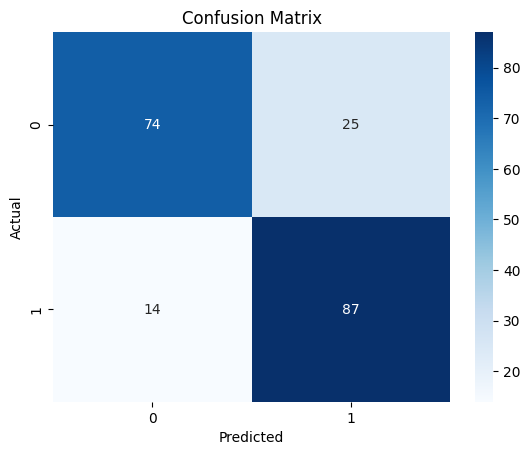

In [12]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

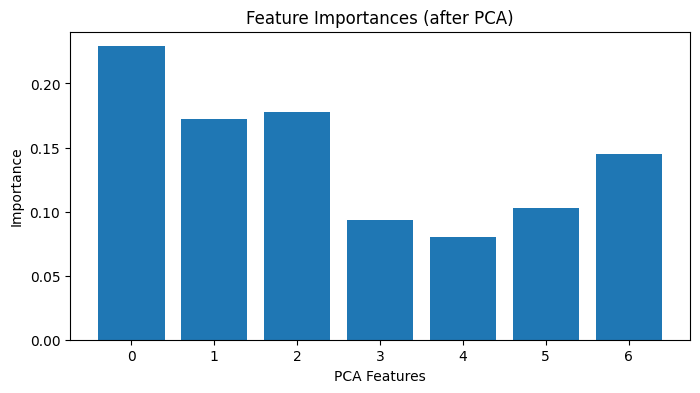

In [13]:
best_rf = grid_rf.best_estimator_
importances = best_rf.feature_importances_

plt.figure(figsize=(8, 4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances (after PCA)")
plt.xlabel("PCA Features")
plt.ylabel("Importance")
plt.show()

Visualisasi tersebut menunjukkan tingkat kepentingan (importance) dari masing-masing fitur utama (principal components) setelah dilakukan analisis komponen utama (PCA). Sumbu horizontal (x-axis) merepresentasikan indeks dari fitur-fitur utama (0 hingga 6), sedangkan sumbu vertikal (y-axis) menunjukkan nilai kepentingan untuk setiap fitur utama. Dari diagram ini, terlihat bahwa fitur utama ke-0 memiliki tingkat kepentingan yang paling tinggi, diikuti oleh fitur utama ke-2 dan ke-1 yang juga memiliki tingkat kepentingan yang cukup signifikan. Fitur-fitur utama lainnya (3, 4, 5, dan 6) memiliki tingkat kepentingan yang relatif lebih rendah dalam menjelaskan varians data setelah transformasi PCA.